In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


/home/user/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
# Define transforms for dataset
transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.ToTensor(),
    transforms.Normalize([0.3337, 0.3064, 0.3171], [0.2672, 0.2564, 0.2629])
])

# Load dataset
# original_dataset_dir = '/home/iai/Desktop/bsh/active_learning/data/mvtec2'
# classes_list = os.listdir(original_dataset_dir)

train_dataset = ImageFolder(root='/home/user/Desktop/bsh/mvtec_data_multi/train/zipper', transform=transform)
test_dataset = ImageFolder(root='/home/user/Desktop/bsh/mvtec_data_multi/test/zipper', transform=transform)

print(len(train_dataset))
print(len(test_dataset))

# print(len(classes_list))

308
83


In [3]:
#Define data loaders
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

In [4]:
# Define loss function and optimizer

EPOCHS = 200

criterion = nn.CrossEntropyLoss()

train_loss_list = []


def train(model, train_loader,optimizer, log_interval):
    model.train()
    train_loss = 0.0
    for _,(image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    
    return train_loss


In [5]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.metrics import precision_recall_fscore_support
import torch.nn.functional as F

test_acc_list = []
test_auc_list = []
test_loss_list = [] 
test_f1_list = []

def evaluate(model, test_loader, n_classes):
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    
    y_true = []
    y_pred = []
    y_pred_prob = []  # 확률 예측

    with torch.no_grad():
        n_samples = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            probs = F.softmax(output, dim=1)  # 모델의 출력에서 softmax 확률을 계산
            test_loss += criterion(output, labels).item()
            _, predicted = torch.max(output, 1)                           
            n_samples += labels.size(0)
            test_accuracy += (predicted == labels).sum().item()
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist()) 
            y_pred_prob.extend(probs.cpu().numpy())  # 확률 예측 저장       
        test_accuracy /= n_samples
        test_loss /= len(test_loader)

        y_true_np = np.array(y_true)
        y_pred_prob_np = np.array(y_pred_prob)
        plot_multiclass_roc(y_true_np, y_pred_prob_np, num_classes)

        # print(y_true_np)
        # print(y_pred_np)
        # print(y_pred_prob_np)

        # Compute confusion matrix, precision, recall, and F1 score
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)

        # Compute per-class AUROC
        auc_score_dict = {}
        for i in range(n_classes):
            y_true_class = [1 if y == i else 0 for y in y_true]
            y_pred_class_prob = y_pred_prob_np[:, i]
            # y_pred_class = [1 if y == i else 0 for y in y_pred]
            auc_score = roc_auc_score(y_true_class, y_pred_class_prob)
            auc_score_dict[i] = auc_score

        # Compute macro-average AUROC
        auc_score_dict["macro"] = roc_auc_score(y_true_np, y_pred_prob_np, average='macro',multi_class = 'ovr')

        return test_loss, test_accuracy, auc_score_dict, f1


In [6]:
# Pretrained : 미리 학습된 resnet18모델을 불러온 후 이미지 데이터에 맞게 Fine Tuning

num_classes = 8                                                    #############################
#"Bottle," 4 "Cable," 9 "Capsule," 6 "Carpet," 6 "Grid," 6 
#"Hazelnut," 5 "Leather," 6 "Metal Nut," 5 "Pill," 8 "Screw," 6
#"Tile," 6 "Toothbrush," 2 "Transistor," 5 "Wood," 6 "Zipper" 8

model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
# Because num of class
model.fc = nn.Linear(num_ftrs, num_classes)                   
model = model.cuda()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_multiclass_roc(y_true, y_pred_prob, n_classes, figsize=(17, 6)):
    # 플롯을 위한 설정
    lw = 2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # 각 클래스에 대한 ROC 곡선과 AUROC를 계산합니다
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 모든 클래스의 평균 FPR, TPR 및 AUROC를 계산합니다
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # ROC 곡선을 그립니다
    plt.figure(figsize=figsize)
    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [8]:
for EPOCH in range(EPOCHS):
    train(model, train_loader, optimizer, log_interval = 5)
    train_loss = train(model, train_loader, optimizer, log_interval = 5)
    train_loss_list.append(train_loss)
    
    print("[EPOCH:{}],\tTrain Loss: {:.4f}".format(EPOCH+1, train_loss))

    # 모델 저장 (현재 손실이 이전 최상의 손실보다 낮을 때)
    if EPOCH == 0 or train_loss < best_loss:
        best_loss = train_loss
        torch.save(model.state_dict(), 'best_multi_ideal_model.pth')  # 모델의 파라미터 저장

[EPOCH:1],	Train Loss: 1.5748
[EPOCH:2],	Train Loss: 1.0794
[EPOCH:3],	Train Loss: 0.8873
[EPOCH:4],	Train Loss: 0.6582
[EPOCH:5],	Train Loss: 0.4516
[EPOCH:6],	Train Loss: 0.2090
[EPOCH:7],	Train Loss: 0.0934
[EPOCH:8],	Train Loss: 0.0500
[EPOCH:9],	Train Loss: 0.0317
[EPOCH:10],	Train Loss: 0.0226
[EPOCH:11],	Train Loss: 0.0176
[EPOCH:12],	Train Loss: 0.0145
[EPOCH:13],	Train Loss: 0.0124
[EPOCH:14],	Train Loss: 0.0108
[EPOCH:15],	Train Loss: 0.0095
[EPOCH:16],	Train Loss: 0.0085
[EPOCH:17],	Train Loss: 0.0077
[EPOCH:18],	Train Loss: 0.0071
[EPOCH:19],	Train Loss: 0.0065
[EPOCH:20],	Train Loss: 0.0061
[EPOCH:21],	Train Loss: 0.0057
[EPOCH:22],	Train Loss: 0.0053
[EPOCH:23],	Train Loss: 0.0050
[EPOCH:24],	Train Loss: 0.0047
[EPOCH:25],	Train Loss: 0.0045
[EPOCH:26],	Train Loss: 0.0043
[EPOCH:27],	Train Loss: 0.0040
[EPOCH:28],	Train Loss: 0.0038
[EPOCH:29],	Train Loss: 0.0037
[EPOCH:30],	Train Loss: 0.0035
[EPOCH:31],	Train Loss: 0.0033
[EPOCH:32],	Train Loss: 0.0032
[EPOCH:33],	Train

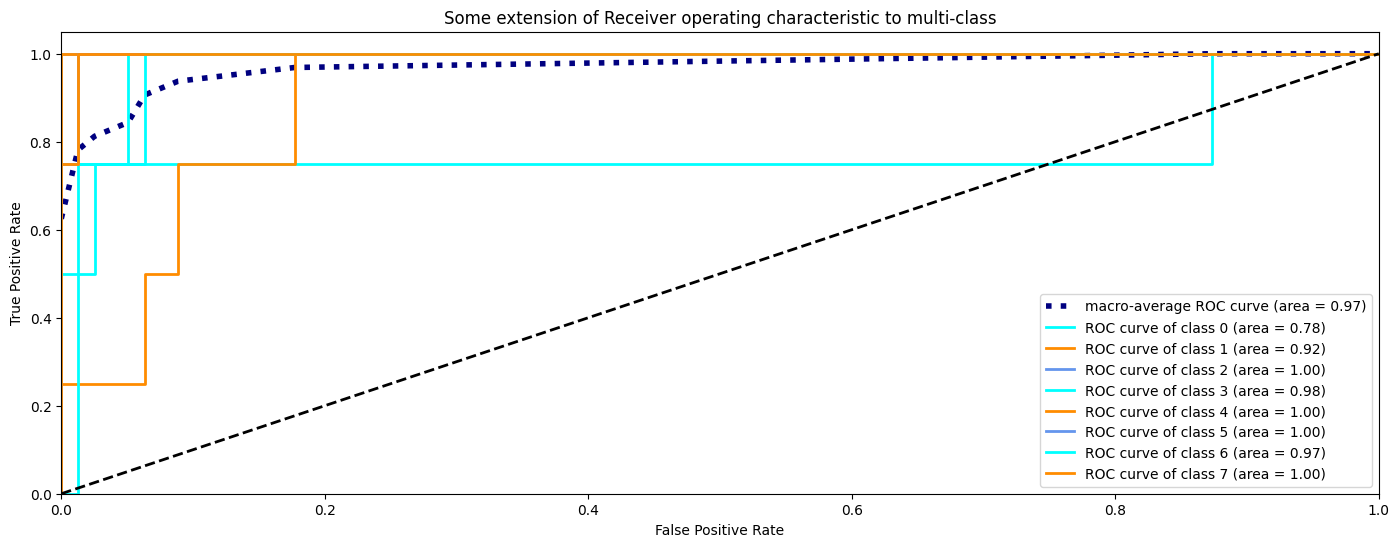

-------------------------------------------------------------------
Test Loss: 0.5955, Test Accuracy: 0.8313, Average Macro AUROC: 0.9561, Test F1 Score: 0.4758
-------------------------------------------------------------------


In [9]:
# 모델을 불러올 준비
best_model = model
best_model.load_state_dict(torch.load('best_multi_ideal_model.pth'))  # 저장된 모델 파라미터를 불러옴
best_model.to(device)  # 디바이스 설정
best_model.eval()  # 모델을 평가 모드로 설정

test_loss, test_accuracy, auc_score_dict, test_f1 = evaluate(model, test_loader, num_classes)

test_acc_list.append(test_accuracy)
test_loss_list.append(test_loss)
test_f1_list.append(test_f1)  # F1 score를 리스트에 추가

# AUROC를 리스트에 추가
for i in range(num_classes):
    test_auc_list.append(auc_score_dict[i])

# Micro and macro averages를 리스트에 추가
test_auc_list.append(auc_score_dict["macro"])

# 평균 AUROC를 계산 및 출력

avg_auc_macro = np.mean(test_auc_list)

print("-------------------------------------------------------------------")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Average Macro AUROC: {avg_auc_macro:.4f}, Test F1 Score: {test_f1:.4f}")
print("-------------------------------------------------------------------")

In [10]:
print("[Test accuracy :{}]".format(test_acc_list))
print("[Test loss :{}]".format(test_loss_list))

print(train_loss_list)


[Test accuracy :[0.8313253012048193]]
[Test loss :[0.595478355884552]]
[1.574795924127102, 1.0793770253658295, 0.8872625976800919, 0.658155545592308, 0.4515737220644951, 0.20901373028755188, 0.09343321854248643, 0.04999513062648475, 0.03171411366201937, 0.02255020011216402, 0.017585672554560006, 0.014492288581095636, 0.012364198570139706, 0.010780966724269092, 0.009521740314085037, 0.008503969758749008, 0.007701686583459377, 0.007067910337354988, 0.006541169132106006, 0.006085099914344028, 0.005687675205990672, 0.005336485599400476, 0.005022201512474567, 0.00473986251745373, 0.004485102428589016, 0.004252717946656048, 0.004040625091874972, 0.0038464094104710966, 0.0036677442549262196, 0.003503132931655273, 0.003349417689605616, 0.0032077410724014044, 0.0030757101048948243, 0.0029526063008233905, 0.0028377803246257827, 0.0027298803470330313, 0.002628043250297196, 0.0025327188486699015, 0.002443140430841595, 0.002358578552957624, 0.00227864456246607, 0.0022032204142306, 0.002131417073542

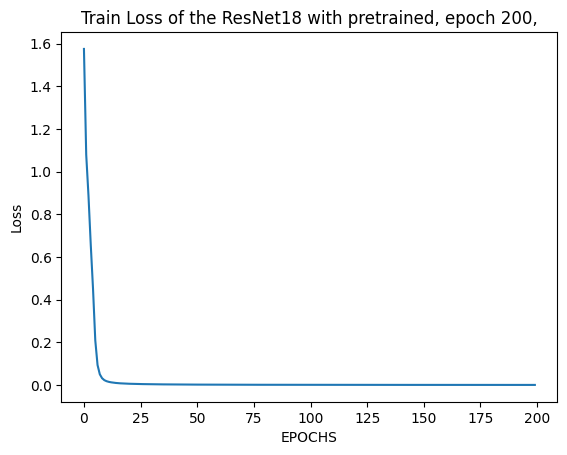

In [11]:
plt.plot(train_loss_list)
plt.xlabel('EPOCHS')
plt.ylabel('Loss')
plt.title('Train Loss of the ResNet18 with pretrained, epoch {},'.format(EPOCHS))
plt.legend
plt.show()